# Dependencies

In [26]:
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import osascript
from gtts import gTTS 
import os 
import pyaudio
import wave
import keyboard  # using module keyboard
import soundfile as sf
import math
import pyloudnorm as pyln
from sys import byteorder
from array import array
from struct import pack
from scipy.signal import butter, sosfiltfilt, sosfreqz

# Constants

In [42]:
THRESHOLD = 100
CHUNK_SIZE = 2048
FORMAT = pyaudio.paInt16
RATE = 44100
AVG_STEP = 75
PERCENTILE= 70
BANDPASS_FREQ = [300, 400]

# Record Audio

#### Record from microphone

 Record a word or words from the microphone and return the data as an array of signed shorts.

Normalizes the audio, trims silence from the start and end, and pads with 0.5 seconds of 
blank sound to make sure VLC et al can play it without getting chopped off.

In [8]:
def record():
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 60:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

#     r = trim(r)
#     r = add_silence(r, 0.5)
    return sample_width, r

#### Save to wav file

In [9]:
def record_to_file(path):
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

#### Checks if input is silent based on threshold

In [10]:
def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

# Preprocessing

#### Trim input to remove silence at beginning and end

In [11]:
def trim(snd_data):
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)
            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

#### Pad with silence at beginning and end

In [12]:
def add_silence(snd_data, seconds):
    ""
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

#### Process wav input with highpass filter

In [52]:
def voice_input(voice_data):
    fs, data = wavfile.read(voice_data)
    number_of_samples = data.shape#### Pad with silence at beginning and end
    data = butter_bandpass_filter(data, BANDPASS_FREQ[0], BANDPASS_FREQ[1], fs)
    return data, fs

#### Implement butter bandpass filter

In [53]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

# Loudness Algorithm

#### Get amplitude curve and apply regression on ITU-R BS.1770-4 loudness algorithm

In [16]:
def getting_loudness3(data, rate):
    plt.figure(0)
    plt.plot(data)
    
    # Average data by step size to percentile
    avg_data = np.percentile(data[:(len(data)//AVG_STEP)*AVG_STEP].reshape(-1,AVG_STEP),
                             PERCENTILE, axis=1)
    
    #apply hilbert envelope
    hilbert_transformed = np.abs(scipy.signal.hilbert(avg_data))

    #Smooth out hilbert 
    b, a = scipy.signal.ellip(4, 0.01, 120, 0.125)
    fgust = scipy.signal.filtfilt(b, a, hilbert_transformed, method="gust")
    plt.figure(1)
    plt.plot(avg_data)
    plt.plot(fgust)

    #remove silence 
    avg = np.mean(fgust)
    silenced = remove_silence_from(fgust, avg)
    plt.figure(2)
    plt.plot(silenced)
    data = [float(i) for i in silenced]
    data = np.array(data)

    # measure the loudness first 
    meter = pyln.Meter(rate/500) # create BS.1770 meter
    loudness = meter.integrated_loudness(data)
    print("lds: "+ str(loudness))
    #return the exponential regression
    return (loudness)

#### Remove silence before, after, and in-between voice data

In [17]:
def remove_silence_from(amplitudes, threshold):
    silenced = []
    for x in amplitudes:
        if x >= threshold:
            silenced.append(x)
    return silenced# Preprocessing

#### Exponential Regression that returns loudness from 0 to 100 given ITU-R loudness score

In [18]:
def exp_reg(loudness):
    return 1.619772149*1.128504719**loudness

# Response

#### Sets a new volume that is spoken at for the user

In [19]:
def reply(user_volume):
    speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
    print("speaker volume is " + str(speaker_volume))
    print("user volume is "+ str(user_volume))
    if(speaker_volume < user_volume):
        new_volume = speaker_volume + (((speaker_volume - user_volume)**2) /100)
    else:
        new_volume = speaker_volume - (((speaker_volume - user_volume)**2) /100)
    print("speaker new volume is " + str(new_volume))
    osascript.osascript("set volume output volume "+ str(new_volume)) 
    thing_to_say = 'hello your volume is at '+ str(int(new_volume))
    print(thing_to_say)
    os.system("say "+ thing_to_say)

# Main

In [20]:
    print("please speak a word into the microphone")
    record_to_file('voiceLevels/ronak-01.wav')
    print("done - result written to demo.wav")

please speak a word into the microphone
done - result written to demo.wav


please speak a word into the microphone
done - result written to demo.wav
lds: -6.641882885950444
speaker volume is 0
user volume is -6
speaker new volume is -0.36
hello your volume is at 0


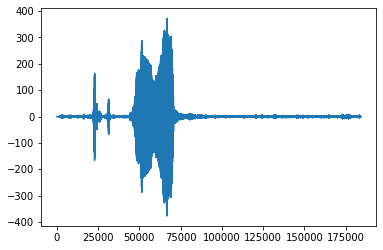

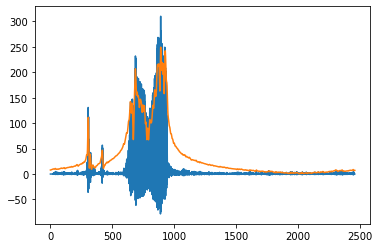

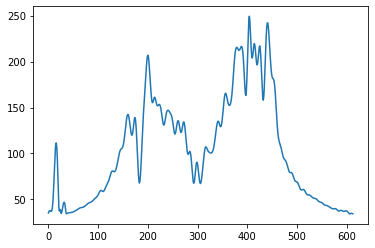

In [54]:
import time
if __name__ == '__main__':
    time.sleep(0.5)
    print("please speak a word into the microphone")
    
    record_to_file('demo.wav')
    print("done - result written to demo.wav")
    data, rate = voice_input('demo.wav')
    new_volume = getting_loudness3(data, rate)
    reply(int(new_volume))

In [ ]:
    data, rate = voice_input('demo.wav')
    new_volume = getting_loudness3(data, rate)
    reply(int(new_volume))